In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.image as mpimg
import math
import os
import warnings
import datetime
from tensorflow.keras.applications import *
import json
import time
import nbformat
warnings.filterwarnings('ignore')
%run "./src/core_function.ipynb"

In [19]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [20]:
## Define directories for training and testing data
TRAIN_DIR = r'./dataset/train/'
TEST_DIR = r'./dataset/test/'
# VAL_DIR = r'./data/val/'

# Directory to save the trained model
SAVED_MODEL_DIR = r'Saved_model'

# Number of classes in the classification task
CLASS_NUM = 5

# Set a seed for random number generation (for reproducibility)
SEED = 1

# Batch size for training
BATCH_SIZE = 32

# Number of epochs for training
EPOCHS = 10

# Size of the input images
IMAGE_SIZE = 224

# Split ratio for validation data
VALIDATION_SPLIT = 0.2  # 0-1

# Learning rate for the optimizer
LEARNING_RATE = 0.010  # 0.001

# # Name of the base model (checking function not provided in this code snippet)
MODEL_BASE_NAME = check_base_model('ResNet50')  #from core_function.ipynb

# Define the loss function for training
LOSS = "sparse_categorical_crossentropy"

# Define the optimizer to be used for training
OPTIMIZER = check_optimizer("SGD")  # SGD, Adam, Nadam

# Name of the computer used for training (for tracking purposes)
PC_NAME = "KOFirst"  ### Set pc name using to combined Compute times

# List of available models (link provided in the code)
# https://keras.io/api/applications/

Using ResNet50 as base conv
Using SGD as base optimizers


In [21]:
## Define Folder for saving model results
current_time = get_current_time() #from core_function.ipynb
SavingModelPath = create_saving_path(SAVED_MODEL_DIR, MODEL_BASE_NAME) #from core_function.ipynb

In [22]:
# Define whether to use early stopping during training
USING_EARLY_STOPPING = True

# Define whether to use learning rate reduction during training
USING_REDUCE_LR = True

# Define whether to use model checkpointing during training
USING_CHECKPOINT = True

# Define early stopping callback with specific parameters
EARLY_STOPPING = callbacks.EarlyStopping(
    monitor="val_loss",          # Monitor validation loss
    min_delta=0.001,             # Minimum change in the monitored quantity
    patience=7,                  # Number of epochs with no improvement after which training will be stopped
    verbose=1,                   # Verbosity mode (1 for updates, 0 for silent)
    mode="auto",                 # Direction of improvement (auto selects based on the monitored quantity)
    baseline=None,               # Baseline value for early stopping
    restore_best_weights=True     # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define learning rate reduction callback with specific parameters
REDUCE_LR = callbacks.ReduceLROnPlateau(
    monitor="val_loss",          # Monitor validation loss
    factor=0.3,                  # Factor by which the learning rate will be reduced
    patience=3,                  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,                   # Verbosity mode (1 for updates, 0 for silent)
    mode="auto",                 # Direction of improvement (auto selects based on the monitored quantity)
    min_delta=0.0001,            # Minimum change in the monitored quantity to be considered an improvement
    cooldown=0,                  # Number of epochs to wait before resuming normal operation after learning rate is reduced
    min_lr=1e-6                  # Lower bound on the learning rate
)

# Define model checkpointing callback with specific parameters
MODEL_CHECKPOINT = callbacks.ModelCheckpoint(
    os.path.join(SavingModelPath, "H5Model_"+MODEL_BASE_NAME+"_SavedEpoch.h5"),  # Filepath to save the model
    monitor="val_acc",          # Monitor validation accuracy
    verbose=1,                   # Verbosity mode (1 for updates, 0 for silent)
    save_best_only=True,        # Only save the best model (based on the monitored quantity)
    save_weights_only=False,    # Save the entire model, not just the weights
    mode="auto",                # Direction of improvement (auto selects based on the monitored quantity)
    save_freq="epoch"           # Frequency at which to save the model (in epochs)
)

class cbb : 1000015157.jpg
class cbsd : 100042118.jpg
class cgm : 1000910826.jpg
class cmd : 100204014.jpg
class healthy : 1001723730.jpg


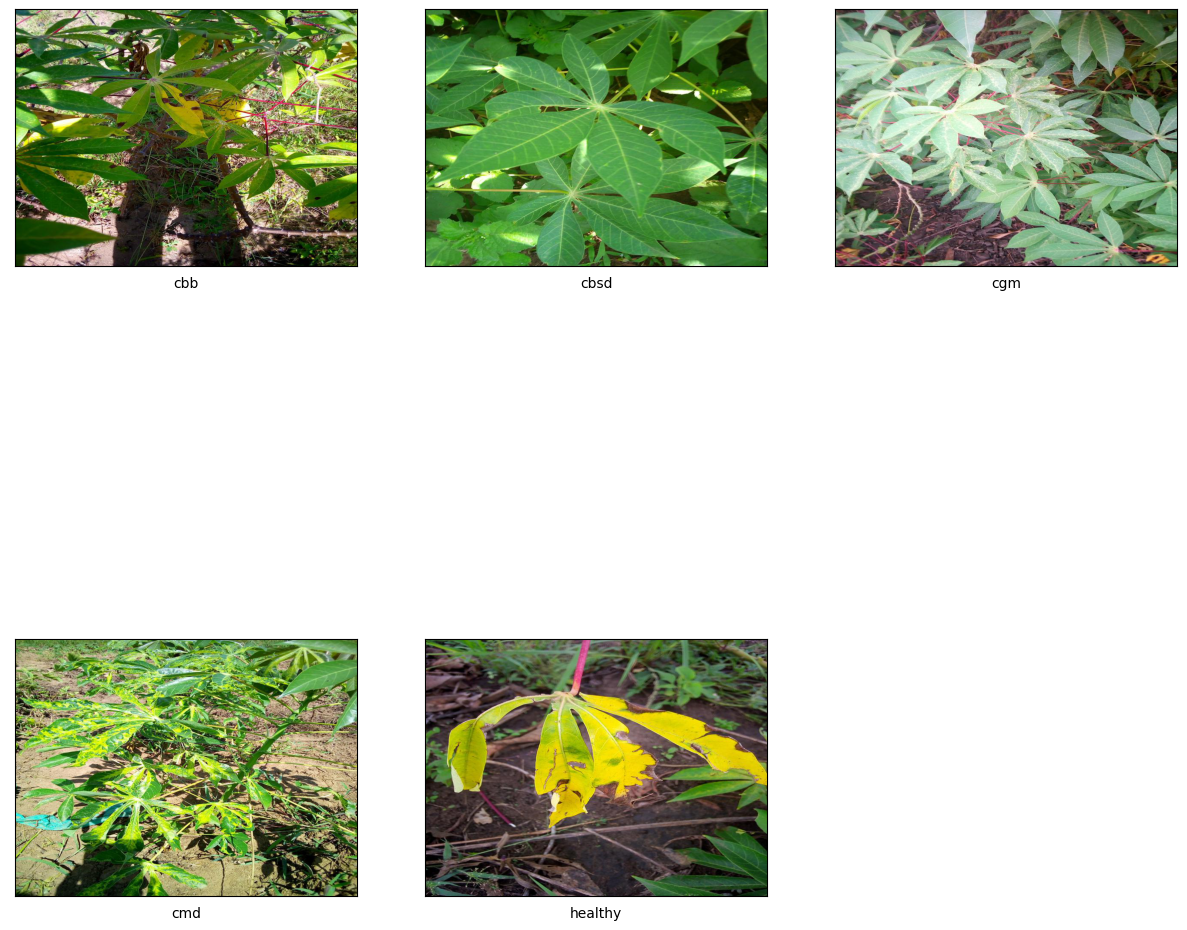

In [23]:
plot_images_from_directory(TRAIN_DIR) #from core_function.ipynb

In [24]:
print("TRAINING DATA:")
print_directory_info(TRAIN_DIR) #from core_function.ipynb

print("\n\nTEST DATA:")
print_directory_info(TEST_DIR) #from core_function.ipynb

TRAINING DATA:
cbb : 2779 files
cbsd : 3095 files
cgm : 3302 files
cmd : 3288 files
healthy : 3280 files


TEST DATA:
cbb : 327 files
cbsd : 345 files
cgm : 374 files
cmd : 360 files
healthy : 344 files


In [25]:
# Create train, validation, and test datasets
print("--- Train ---")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR, validation_split=VALIDATION_SPLIT, subset="training", seed=SEED, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)

print("--- Validation ---")

val_ds = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR, validation_split=VALIDATION_SPLIT, subset="validation", seed=SEED, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)

--- Train ---
Found 15744 files belonging to 5 classes.
Using 12596 files for training.
--- Validation ---
Found 15744 files belonging to 5 classes.
Using 3148 files for validation.


In [26]:
print("--- Test ---")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR, seed=SEED, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)

--- Test ---
Found 1750 files belonging to 5 classes.


In [27]:
# Get the class names from the dataset
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']


In [28]:
## Preprocess AUTOTUNE datasets
train_ds, val_ds, test_ds = AUTOTUNE(train_ds, val_ds, test_ds)
#https://www.tensorflow.org/guide/data_performance

In [29]:
# Get the model class from the global namespace
model_class = globals()[MODEL_BASE_NAME]
conv_base = model_class(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
conv_base.trainable = False

In [30]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

Model_Layer_Style = "OriginalBon"  #Define name of Model Layer
### From Bon
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(CLASS_NUM, activation='softmax')(x)
model = Model(inputs=conv_base.input, outputs=predictions)


# Model_Layer_Style = "SuperBon"  #Define name of Model Layer
# ### From Bon
# x = conv_base.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
# x = Dropout(0.5)(x)
# predictions = Dense(CLASS_NUM, activation='softmax')(x)
# model = Model(inputs=conv_base.input, outputs=predictions)


# Model_Layer_Style = "SuperiorBon"
# x = conv_base.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
# x = Dropout(0.5)(x)
# predictions = Dense(CLASS_NUM, activation='softmax')(x)
# model = Model(inputs=conv_base.input, outputs=predictions)

# Model_Layer_Style = "OriginalTam"  #Define name of Model Layer
# ### From Tam
# x = conv_base.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256)(x)
# x = Activation('relu')(x)
# x = tf.keras.layers.LeakyReLU(alpha=0.3)(x)
# # x = Dropout(0.5)(x)
# predictions = Dense(CLASS_NUM, activation='softmax')(x)
# model = Model(inputs=conv_base.input, outputs=predictions)

# Model_Layer_Style = "OriginalTam + SuperBon = SuperTam"  #Define name of Model Layer
# ### From Tam
# x = conv_base.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
# x = Activation('relu')(x)
# x = tf.keras.layers.LeakyReLU(alpha=0.3)(x)
# x = Dropout(0.5)(x)
# predictions = Dense(CLASS_NUM, activation='softmax')(x)
# model = Model(inputs=conv_base.input, outputs=predictions)


In [31]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [32]:
Model_Freeze_Style = "None"

if Model_Freeze_Style == "None":
    next

elif Model_Freeze_Style == "FreezeAll":
    for layer in conv_base.layers:
        layer.trainable = False

elif Model_Freeze_Style == "FreezeSome":
    freeze_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1']
    for layer in conv_base.layers:
        if layer.name in freeze_layers:
            layer.trainable = False

In [33]:
model.compile(loss=LOSS, optimizer=getattr(optimizers, OPTIMIZER)(learning_rate=LEARNING_RATE), metrics=['acc'])

In [34]:
def create_callbacks():
    callback = []
    if(USING_EARLY_STOPPING):
        callback.append(EARLY_STOPPING)
    if(USING_REDUCE_LR):
        callback.append(REDUCE_LR)
    if(USING_CHECKPOINT):
        callback.append(MODEL_CHECKPOINT)
    return callback


history = model.fit(
                        train_ds,
                        epochs = EPOCHS,
                        validation_data = val_ds,
                        callbacks=create_callbacks(),
                        verbose= 1
                     )

Epoch 1/10
394/394 [==============================] - ETA: 0s - loss: 0.9478 - acc: 0.6323
Epoch 00001: val_acc improved from -inf to 0.73030, saving model to Saved_model/ResNet50_20231127_204650\H5Model_ResNet50_SavedEpoch.h5
394/394 [==============================] - 139s 354ms/step - loss: 0.9478 - acc: 0.6323 - val_loss: 0.7342 - val_acc: 0.7303
Epoch 2/10
394/394 [==============================] - ETA: 0s - loss: 0.3435 - acc: 0.8867
Epoch 00002: val_acc improved from 0.73030 to 0.83513, saving model to Saved_model/ResNet50_20231127_204650\H5Model_ResNet50_SavedEpoch.h5
394/394 [==============================] - 127s 322ms/step - loss: 0.3435 - acc: 0.8867 - val_loss: 0.4943 - val_acc: 0.8351
Epoch 3/10
394/394 [==============================] - ETA: 0s - loss: 0.1006 - acc: 0.9736
Epoch 00003: val_acc improved from 0.83513 to 0.87770, saving model to Saved_model/ResNet50_20231127_204650\H5Model_ResNet50_SavedEpoch.h5
394/394 [==============================] - 126s 320ms/step - lo

In [35]:
model.save(os.path.join(SavingModelPath, "H5Model_"+MODEL_BASE_NAME+"_LastEpoch.h5"))

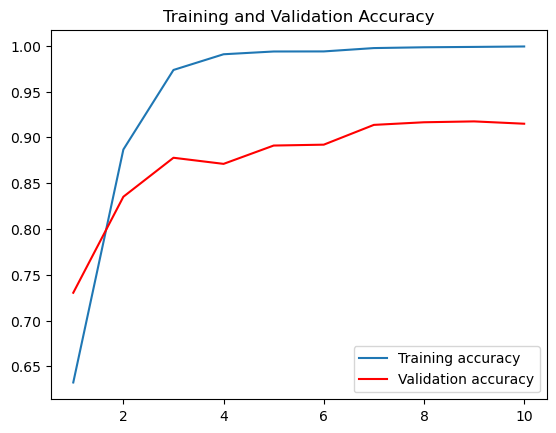

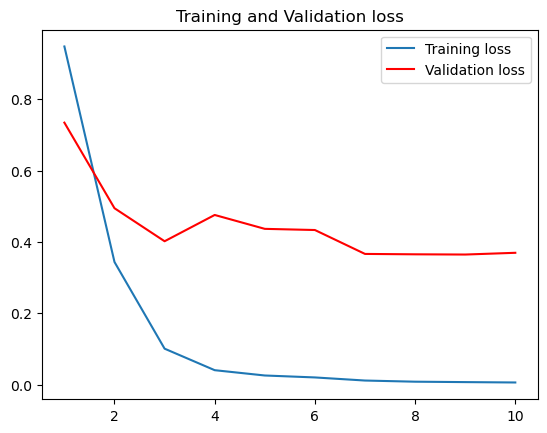

Average Validation loss:  0.4440377503633499
Average Validation accuracy: 87.60 %


In [36]:
plot_acc_loss(history)

Plotting SavedEpoch Model
Test Accuracy: 0.8977142857142857


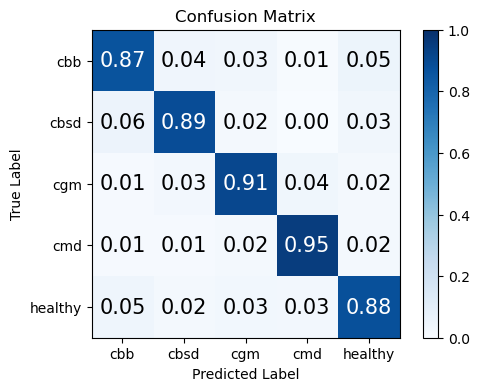

              precision    recall  f1-score   support

           0    0.87077   0.86544   0.86810       327
           1    0.90000   0.88696   0.89343       345
           2    0.90642   0.90642   0.90642       374
           3    0.92916   0.94722   0.93810       360
           4    0.87791   0.87791   0.87791       344

    accuracy                        0.89771      1750
   macro avg    0.89685   0.89679   0.89679      1750
weighted avg    0.89756   0.89771   0.89761      1750


Plotting LastEpoch Model
Test Accuracy: 0.8994285714285715


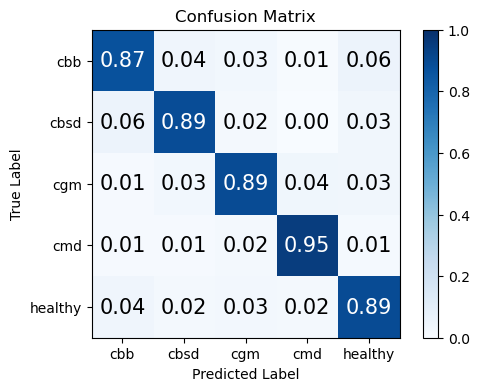

              precision    recall  f1-score   support

           0    0.87423   0.87156   0.87289       327
           1    0.90029   0.88986   0.89504       345
           2    0.91507   0.89305   0.90392       374
           3    0.93425   0.94722   0.94069       360
           4    0.86969   0.89244   0.88092       344

    accuracy                        0.89943      1750
   macro avg    0.89871   0.89883   0.89869      1750
weighted avg    0.89955   0.89943   0.89942      1750



In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model




# Load the saved model
saved_model_path =  os.path.join(SavingModelPath, "H5Model_"+MODEL_BASE_NAME+"_SavedEpoch.h5")
if os.path.exists(saved_model_path):
    print("Plotting SavedEpoch Model")
    model = load_model(saved_model_path)
    accuracySavedEpoch, elapsed_timeSavedEpoch, reportSavedEpoch = plot_confusion_matrix(test_ds, SavingModelPath, model, MODEL_BASE_NAME+"_SavedEpoch")
    print(reportSavedEpoch)
else:
    print("SavedEpoch model not found")
print("")
saved_model_path =  os.path.join(SavingModelPath, "H5Model_"+MODEL_BASE_NAME+"_LastEpoch.h5")
if os.path.exists(saved_model_path):
    print("Plotting LastEpoch Model")
    model = load_model(saved_model_path)
    accuracyLastEpoch, elapsed_timeLastEpoch, reportLastEpoch = plot_confusion_matrix(test_ds, SavingModelPath, model, MODEL_BASE_NAME+"_LastEpoch")
    print(reportLastEpoch)
else:
    print("LastEpoch model not found")

elapsed_time = (elapsed_timeSavedEpoch+elapsed_timeLastEpoch)/2

In [38]:
import openpyxl
reportSavedEpoch = report_to_list(reportSavedEpoch, class_names)
reportLastEpoch = report_to_list(reportLastEpoch, class_names)
Column = reportSavedEpoch[0]
Column[0] = "Model Reports"
reportSavedEpoch[0][0] = "Report Saved Epoch Model"
reportLastEpoch[0][0] = "Report Last Epoch Model"

results = pd.DataFrame(columns = reportSavedEpoch[0])
# results = results.append(pd.DataFrame([["Report Saved Epoch Model", " ", " ", " ", " "]], columns=reportSavedEpoch[0]), ignore_index=True)
i=0
for row in reportSavedEpoch:
    i=i+1
    if(i==1):
        next
    results = results.append(pd.DataFrame([row], columns=Column), ignore_index=True)

results = results.append(pd.DataFrame([[" ", " ", " ", " ", " "]], columns=Column), ignore_index=True)
# results = results.append(pd.DataFrame([["Report Last Epoch Model", " ", " ", " ", " "]], columns=reportSavedEpoch[0]), ignore_index=True)
i=0
for row in reportLastEpoch:
    i=i+1
    if(i==1):
        next
    results = results.append(pd.DataFrame([row], columns=Column), ignore_index=True)


results.reset_index(drop=True)
results.to_excel(SavingModelPath + "/" + "ModelResults.xlsx", index=False)


In [39]:
settings = pd.DataFrame(columns = ['Variable' , 'Value'])

rows = [
    ["Model Info", ""],
    ["Model_Base", MODEL_BASE_NAME],
    ["Model_Layer_Style", Model_Layer_Style],
    ["Model_Freeze", Model_Freeze_Style],
    ["OPTIMIZER", OPTIMIZER],
    ["", ""]
]
new_rows = pd.DataFrame(rows, columns=["Variable", "Value"])
settings = settings.append(new_rows, ignore_index=True)

rows = [
    ["Setting", ""],
    ["TRAIN_DIR", TRAIN_DIR],
    ["TEST_DIR", TEST_DIR],
    ["SAVED_MODEL_DIR", SAVED_MODEL_DIR],
    ["CLASS_NUM", CLASS_NUM],
    ["SEED", SEED],
    ["BATCH_SIZE", BATCH_SIZE],
    ["EPOCHS", EPOCHS],
    ["IMAGE_SIZE", str(IMAGE_SIZE)+" x "+str(IMAGE_SIZE)],
    ["VALIDATION_SPLIT", VALIDATION_SPLIT],
    ["LEARNING_RATE", LEARNING_RATE],
    ["class_names", class_names],
    ["LOSS", LOSS],
    ["", ""],
]
new_rows = pd.DataFrame(rows, columns=["Variable", "Value"])
settings = settings.append(new_rows, ignore_index=True)

rows = [
    ["Result", ""],
    ["Accuracy SavedEpoch", str(round(accuracySavedEpoch, 10))],
    ["Accuracy LastEpoch", str(round(accuracyLastEpoch, 10))],
    ["PC", PC_NAME],
    ["Runtimes", elapsed_time],
    ["", ""]
]
new_rows = pd.DataFrame(rows, columns=["Variable", "Value"])
settings = settings.append(new_rows, ignore_index=True)



if(USING_EARLY_STOPPING or USING_REDUCE_LR or USING_CHECKPOINT):
    rows = [
        ["Callback", ""],
    ]


    new_rows = pd.DataFrame(rows, columns=["Variable", "Value"])
    settings = settings.append(new_rows, ignore_index=True)

if(USING_EARLY_STOPPING):
    rows = [
        ["USING_EARLY_STOPPING", USING_EARLY_STOPPING],
        ["EARLY_STOPPING", get_early_stopping_settings_string(EARLY_STOPPING)],
    ]
    new_rows = pd.DataFrame(rows, columns=["Variable", "Value"])
    settings = settings.append(new_rows, ignore_index=True)

if(USING_REDUCE_LR):
    rows = [
        ["USING_REDUCE_LR", USING_REDUCE_LR],
        ["REDUCE_LR", get_reduce_lr_settings_string(REDUCE_LR)],
    ]
    new_rows = pd.DataFrame(rows, columns=["Variable", "Value"])
    settings = settings.append(new_rows, ignore_index=True)

if(USING_CHECKPOINT):
    rows = [
        ["USING_CHECKPOINT", USING_CHECKPOINT],
        ["MODEL_CHECKPOINT", get_checkpoint_settings_string(MODEL_CHECKPOINT)],
    ]
    new_rows = pd.DataFrame(rows, columns=["Variable", "Value"])
    settings = settings.append(new_rows, ignore_index=True)


settings.to_excel(SavingModelPath + "/" + "ModelSetting.xlsx", index=False)


with open(SavingModelPath+"/"+"ModelSetting.txt", "w") as file:
    for index, row in settings.iterrows():
        variable = row["Variable"]
        value = row["Value"]
        file.write(f"{variable}: {value}\n")
